<h1><center> ASSIGNMENT 4</h1>

MADE BY: - 
    
ARYAN OMKAR ASHAR 19BAI10094

In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import cv2
import os
import h5py
images_per_class       = 742
fixed_size             = tuple((500, 500))
train_path             = r"C:\Users\aryan\Downloads/train"
h5_train_data          = r'C:\Users\aryan\Downloads\output/train_data.h5'
h5_train_labels        = r'C:\Users\aryan\Downloads\output/train_labels.h5'
bins                   = 8

In [2]:
def rgb_bgr(image):
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return rgb_img

In [3]:
def bgr_hsv(rgb_img):
    hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
    return hsv_img

In [4]:
def img_segmentation(rgb_img,hsv_img):
    lower_green = np.array([25,0,20])
    upper_green = np.array([100,255,255])
    healthy_mask = cv2.inRange(hsv_img, lower_green, upper_green)
    result = cv2.bitwise_and(rgb_img,rgb_img, mask=healthy_mask)
    lower_brown = np.array([10,0,10])
    upper_brown = np.array([30,255,255])
    disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)
    disease_result = cv2.bitwise_and(rgb_img, rgb_img, mask=disease_mask)
    final_mask = healthy_mask + disease_mask
    final_result = cv2.bitwise_and(rgb_img, rgb_img, mask=final_mask)
    return final_result


In [5]:
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [6]:
def fd_haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

In [7]:
def fd_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

In [8]:
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()
print(train_labels)

# empty lists to hold feature vectors and labels
global_features = []
labels          = []

['diseased', 'healthy']


In [9]:
# loop over the training data sub-folders
for training_name in train_labels:
    # join the training data path and each species training folder
    dir = os.path.join(train_path, training_name)

    # get the current training label
    current_label = training_name

    # loop over the images in each sub-folder
    for x in range(1,images_per_class+1):
        
        file = dir + "/" + "1 (" + str(x) + ")" + ".jpg"

        # read the image and resize it to a fixed-size
        image = cv2.imread(file)
        image = cv2.resize(image, fixed_size)

        
        # Running Function Bit By Bit
        
        RGB_BGR       = rgb_bgr(image)
        BGR_HSV       = bgr_hsv(RGB_BGR)
        IMG_SEGMENT   = img_segmentation(RGB_BGR,BGR_HSV)

        # Call for Global Fetaure Descriptors
        
        fv_hu_moments = fd_hu_moments(IMG_SEGMENT)
        fv_haralick   = fd_haralick(IMG_SEGMENT)
        fv_histogram  = fd_histogram(IMG_SEGMENT)
        
        # Concatenate 
        
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
        
        

        # update the list of labels and feature vectors
        labels.append(current_label)
        global_features.append(global_feature)

    print("[STATUS] processed folder: {}".format(current_label))

print("[STATUS] completed Global Feature Extraction...")


[STATUS] processed folder: diseased
[STATUS] processed folder: healthy
[STATUS] completed Global Feature Extraction...


In [11]:
print("[STATUS] feature vector size {}".format(np.array(global_features).shape))

[STATUS] feature vector size (1484, 532)


In [12]:
print("[STATUS] training Labels {}".format(np.array(labels).shape))

[STATUS] training Labels (1484,)


In [13]:
targetNames = np.unique(labels)
le          = LabelEncoder()
target      = le.fit_transform(labels)
print("[STATUS] training labels encoded...")

[STATUS] training labels encoded...


In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler            = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("[STATUS] feature vector normalized...")

[STATUS] feature vector normalized...


In [15]:
print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))

[STATUS] target labels: [0 0 0 ... 1 1 1]
[STATUS] target labels shape: (1484,)


In [16]:
h5f_data = h5py.File(h5_train_data, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

<HDF5 dataset "dataset_1": shape (1484, 532), type "<f8">

In [17]:
h5f_label = h5py.File(h5_train_labels, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

<HDF5 dataset "dataset_1": shape (1484,), type "<i8">

In [18]:
h5f_data.close()
h5f_label.close()

<h1><center>TRAINING OF THE MODEL

In [19]:
import h5py
import numpy as np
import os
import glob
import cv2
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib
warnings.filterwarnings('ignore')
num_trees = 100
test_size = 0.20
seed      = 9
train_path = r"C:\Users\aryan\Downloads/train"
test_path  = r"C:\Users\aryan\Downloads/test"
h5_train_data    = r'C:\Users\aryan\Downloads\output/train_data.h5'
h5_train_labels  = r'C:\Users\aryan\Downloads\output/train_labels.h5'
scoring    = "accuracy"

# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()

if not os.path.exists(test_path):
    os.makedirs(test_path)

# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))

# variables to hold the results and names
results = []
names   = []

# import the feature vector and trained labels
h5f_data  = h5py.File(h5_train_data, 'r')
h5f_label = h5py.File(h5_train_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

print("[STATUS] training started...")


[STATUS] features shape: (1484, 532)
[STATUS] labels shape: (1484,)
[STATUS] training started...


C:\Users\aryan\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [20]:
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape))

[STATUS] splitted train and test data...
Train data  : (1187, 532)
Test data   : (297, 532)


In [21]:
trainDataGlobal

array([[0.93700763, 0.09545336, 0.27868489, ..., 0.01059011, 0.12692151,
        0.9758464 ],
       [0.95769513, 0.        , 0.00947421, ..., 0.01058886, 0.12693384,
        0.97585098],
       [0.96844576, 0.00263477, 0.00212369, ..., 0.01058887, 0.12693766,
        0.97585094],
       ...,
       [0.77039234, 0.        , 0.        , ..., 0.01058886, 0.12693296,
        0.97585098],
       [0.96965597, 0.        , 0.        , ..., 0.01058989, 0.1271198 ,
        0.97586123],
       [0.98389776, 0.19183335, 0.15462199, ..., 0.01058898, 0.12695993,
        0.97585016]])

LR: 0.910675 (0.018653)
LDA: 0.893804 (0.019166)
KNN: 0.919947 (0.019009)
CART: 0.919954 (0.016633)
RF: 0.952806 (0.022024)
NB: 0.852578 (0.024386)
SVM: 0.908154 (0.018319)


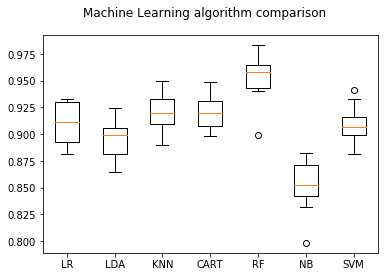

In [22]:
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [23]:
clf  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)

In [24]:
clf.fit(trainDataGlobal, trainLabelsGlobal)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)

In [25]:
y_predict=clf.predict(testDataGlobal)

In [26]:
y_predict

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1], dtype=int6

In [27]:
cm = confusion_matrix(testLabelsGlobal,y_predict)

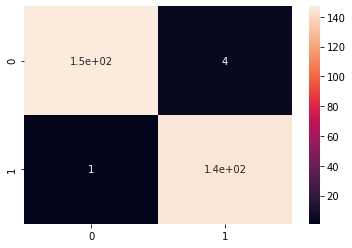

In [28]:
import seaborn as sns
sns.heatmap(cm ,annot=True)

In [29]:
print(classification_report(testLabelsGlobal,y_predict))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       151
           1       0.97      0.99      0.98       146

    accuracy                           0.98       297
   macro avg       0.98      0.98      0.98       297
weighted avg       0.98      0.98      0.98       297



In [30]:
from sklearn.metrics import accuracy_score

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import hsv_to_rgb

In [31]:
accuracy_score(testLabelsGlobal, y_predict)

0.9831649831649831

<h1><center>TESTING OF THE IMAGE

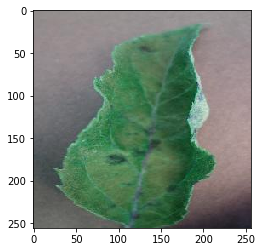

In [33]:
img = cv2.imread(r'C:\Users\aryan\Downloads/testing_image.jpg')
path = 
plt.imshow(img)
plt.show()

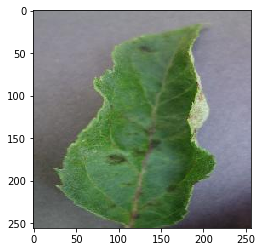

In [34]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

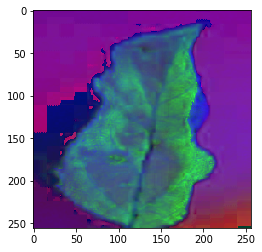

In [35]:
hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
plt.imshow(hsv_img)

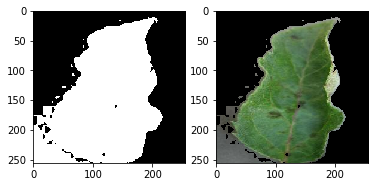

In [36]:
lower_green = np.array([25,0,20])
upper_green = np.array([100,255,255])
mask = cv2.inRange(hsv_img, lower_green, upper_green)
result = cv2.bitwise_and(img, img, mask=mask)
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()


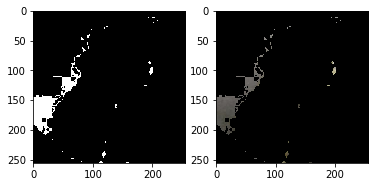

In [37]:
lower_brown = np.array([10,0,10])
upper_brown = np.array([30,255,255])
disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)
disease_result = cv2.bitwise_and(img, img, mask=disease_mask)
plt.subplot(1, 2, 1)
plt.imshow(disease_mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(disease_result)
plt.show()

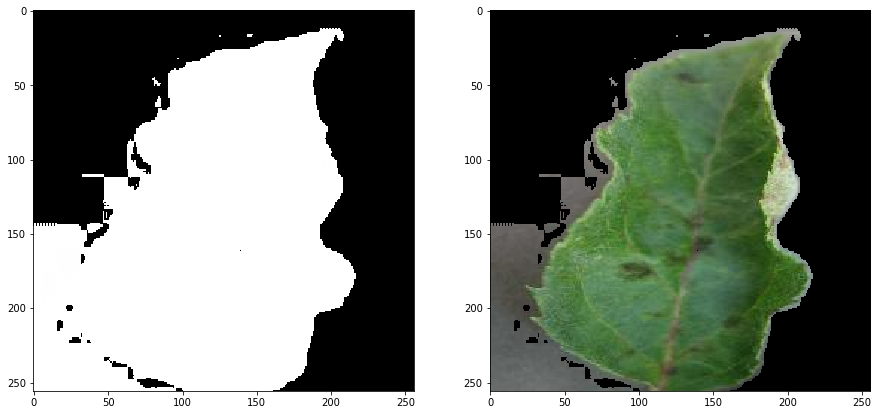

In [38]:
final_mask = mask + disease_mask
final_result = cv2.bitwise_and(img, img, mask=final_mask)
plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.imshow(final_mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(final_result)
plt.show()

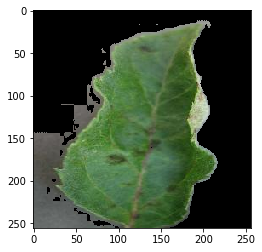

In [40]:
plt.imshow(final_result)

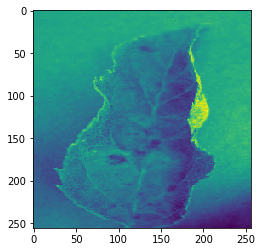

In [57]:
file = (r'C:\Users\aryan\Downloads\testing_image.jpg')
im = cv2.imread(file,cv2.IMREAD_GRAYSCALE)
plt.imshow(im)

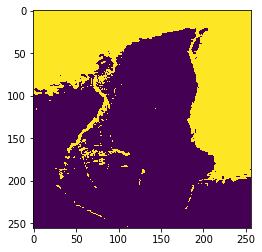

In [58]:
_,im = cv2.threshold(im, 128, 255, cv2.THRESH_BINARY)
plt.imshow(im)

In [59]:
moments = cv2.moments(im)
huMoments = cv2.HuMoments(moments)
print(huMoments)

[[ 1.61198466e-03]
 [ 7.01185814e-07]
 [ 6.76590029e-10]
 [ 1.11789394e-10]
 [-2.44386158e-20]
 [-5.23014252e-14]
 [ 1.86537420e-20]]


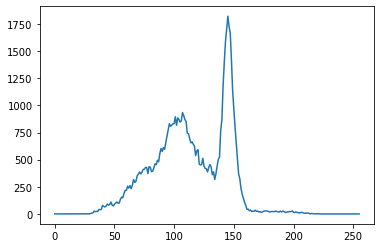

In [60]:
img = cv2.imread(r'C:\Users\aryan\Downloads\testing_image.jpg',0)
histr = cv2.calcHist([img],[0],None,[256],[0,256])
  
plt.plot(histr)
plt.show()

In [61]:
accuracy_score(testLabelsGlobal, y_predict)

0.9831649831649831

In [66]:
print("The accuracy of the prediction is: ")
accuracy_score(testLabelsGlobal, y_predict)*100

The accuracy of the prediction is: 


98.31649831649831